# ML Final Project

In this final project, I will analyze a dataset containing loan eligibility data. The goal is to accurately classify if a loan will be approved based on its features. There are 614 observations. The dataset has 13 columns including one unique ID (Loan_ID) and the target variable. The descriptions of the columns are below.
 
| Columns	| Description |
| :-----------: | :-----------: |
| Loan_ID	| Unique Job ID |
| Gender	| Male/Female |
| Married	| Applicant married (Y/N) |
| Dependents	| Number of dependents |
| Education	| Applicant Education (Graduate/Not Graduate)|
| Self_Employed	| Self employed (Y/N) |
| ApplicantIncome	| Applicant income |
| CoapplicantIncome	| Coapplicant income |
| LoanAmount	| Loan amount in thousands |
| LoanAmountTerm	| Term of loan in months |
| Credit_History	| Credit history meets guidelines |
| Property_Area	| Urban/Semi-Urban/Rural |
| Loan_Status	| (Target) Loan approved (Y/N) |

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [3]:
# read in the file
df = pd.read_csv("Loan_Data.csv")

In [4]:
# take a look at the dataset
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [6]:
# There are a lot of NaN values across the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [7]:
# gauge the breakout between yes and no loan statuses
print(df["Loan_Status"].value_counts())
print(df["Loan_Status"].value_counts(normalize=True))

Y    422
N    192
Name: Loan_Status, dtype: int64
Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64


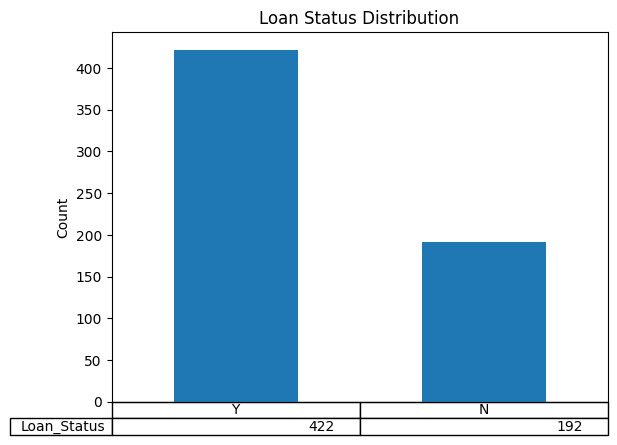

In [8]:
#let's graph the loan statuses

ax = df["Loan_Status"].value_counts().plot(kind='bar',ylabel="Count", 
                                      xlabel="Loan Approved", rot=360,
                                     title="Loan Status Distribution", table=True)
ax.get_xaxis().set_visible(False)   
plt.show()

We see from the above that our dataset is unbalanced. However, we should not be concerned as it is not severely imbalanced. We can proceed with it as is. If it becomes an issue we can try undersampling techniques for future models. 

It will be interesting to see if the intersection of education and gender change the loan status. We will graph it below.

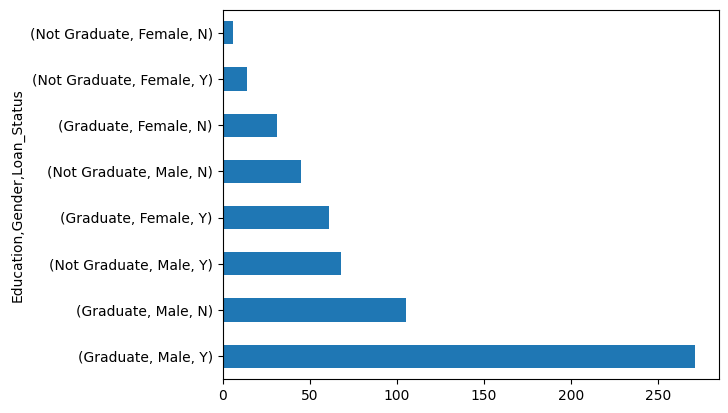

In [9]:
df[["Education","Gender","Loan_Status"]].value_counts().plot(kind="barh", subplots=True)
plt.show()

We see from the above that most of the people with approved loans are male college graduates. There are also a lot more men than women in our dataset overall. This suggests that perhaps women are less likely to seek home loans.

It is fascinating to see that there are more men without degrees that receive loans than there are female graduates that received loans. This could imply gender discrimination. However, we have not looked at differences in income and credit history. Moreover, this type of analysis is not the goal of our machine learning models. It remains an interesting question to ponder.

In [10]:
# before we move on, we should check for duplicates
df.duplicated().sum()

0

### Filling Missing (NaN) Values
We saw a lot of columns with NaN values. We can fill those missing values based on the proportion of the exising values since most of them are non-numeric. For the numeric columns, we will use the mean.

In [11]:
# generate a list of columns with NaN values
nan_columns = df.columns[df.isna().any()].tolist()
nan_columns

['Gender',
 'Married',
 'Dependents',
 'Self_Employed',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [12]:
# check to make sure these columns have NaNs
df[nan_columns].isna().sum()

Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64

In [13]:
df2 = df.copy()

In [14]:
# fill the nan columns with the mean of the other non-null values in those columns
# excluse Credit_History because it is a boolean

df2.loc[:,df2.columns!="Credit_History"] = df2.loc[:,df2.columns!="Credit_History"].fillna(df2.mean(numeric_only=True)) 

In [15]:
# let us make sure we removed the NaN values from those numeric columns
df2[nan_columns].isna().sum()

Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount           0
Loan_Amount_Term     0
Credit_History      50
dtype: int64

In [16]:
# let us start with imputing the Gender column
gender = df2["Gender"].value_counts(normalize=True)
gender

Male      0.813644
Female    0.186356
Name: Gender, dtype: float64

In [17]:
df2.loc[df2["Gender"].isna(), 'Gender'] = np.random.choice(gender.index, p=gender.values, size=df2["Gender"].isna().sum())
df2

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.000000,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.000000,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.000000,360.0,1.0,Urban,Y


In [18]:
# sanity check
df2[nan_columns].isna().sum()

Gender               0
Married              3
Dependents          15
Self_Employed       32
LoanAmount           0
Loan_Amount_Term     0
Credit_History      50
dtype: int64

In [19]:
# imputing the Married column
married = df2["Married"].value_counts(normalize=True)
df2.loc[df2["Married"].isna(), 'Married'] = np.random.choice(married.index, p=married.values, size=df2["Married"].isna().sum())

df2[nan_columns].isna().sum()

Gender               0
Married              0
Dependents          15
Self_Employed       32
LoanAmount           0
Loan_Amount_Term     0
Credit_History      50
dtype: int64

In [20]:
# imputing the Dependents column
dependents = df2["Dependents"].value_counts(normalize=True)
df2.loc[df2["Dependents"].isna(), 'Dependents'] = np.random.choice(dependents.index, p=dependents.values, 
                                                                   size=df2["Dependents"].isna().sum())

df2[nan_columns].isna().sum()

Gender               0
Married              0
Dependents           0
Self_Employed       32
LoanAmount           0
Loan_Amount_Term     0
Credit_History      50
dtype: int64

In [21]:
# imputing the Self_Employed column
self_employed = df2["Self_Employed"].value_counts(normalize=True)
df2.loc[df2["Self_Employed"].isna(), 'Self_Employed'] = np.random.choice(self_employed.index, p=self_employed.values, 
                                                                   size=df2["Self_Employed"].isna().sum())

df2[nan_columns].isna().sum()

Gender               0
Married              0
Dependents           0
Self_Employed        0
LoanAmount           0
Loan_Amount_Term     0
Credit_History      50
dtype: int64

In [22]:
# imputing the Credit_History column
credit_history = df2["Credit_History"].value_counts(normalize=True)
df2.loc[df2["Credit_History"].isna(), 'Credit_History'] = np.random.choice(credit_history.index, p=credit_history.values, 
                                                                   size=df2["Credit_History"].isna().sum())

df2[nan_columns].isna().sum()

Gender              0
Married             0
Dependents          0
Self_Employed       0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
dtype: int64

Great! We were able to impute all the missing values.

In [23]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [24]:
# split the data into X and Y

X = df2.iloc[:,0:-1]
y = df2.iloc[:, -1].values
y = np.where((y == "Y"), 1, 0)

In [25]:
print(X.shape)
print(y.shape)

(614, 12)
(614,)


In [26]:
# one-hot-encode the categorical columns
X = pd.get_dummies(X)

In [27]:
# save the column names for later
long_features = X.columns
X.shape

(614, 634)

In [28]:
# let us check the distribution of the data
X.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID_LP001002,Loan_ID_LP001003,Loan_ID_LP001005,Loan_ID_LP001006,Loan_ID_LP001008,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,...,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.000000,0.838762,0.001629,0.001629,0.001629,0.001629,0.001629,...,0.167752,0.169381,0.083062,0.781759,0.218241,0.859935,0.140065,0.291531,0.379479,0.328990
std,6109.041673,2926.248369,84.037468,64.372489,0.368050,0.040357,0.040357,0.040357,0.040357,0.040357,...,0.373951,0.375394,0.276201,0.413389,0.413389,0.347338,0.347338,0.454838,0.485653,0.470229
min,150.000000,0.000000,9.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,3812.500000,1188.500000,129.000000,360.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see that there is a wide distribution and not all the features are on the same scale. We will need to scale the features.

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [30]:
# let us first split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
# check that the splitting worked correctly
print("X Training Shape:", X_train.shape)
print("Y Training Shape:", y_train.shape)
print("X Test Shape:", X_test.shape)
print("Y Test Shape:", y_test.shape)

X Training Shape: (429, 634)
Y Training Shape: (429,)
X Test Shape: (185, 634)
Y Test Shape: (185,)


In [32]:
# Creating a scaler object
scaler = StandardScaler() 

# Fitting and transforming the original data to scaled data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now that we split our data into training, and testing sets, we can begin building our models. We will start with a logistic regression.

## Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
# lists for the regularization strength and the different solvers
strength = [0.001, 0.01, 0.1, 1, 10]
solvers = ["lbfgs", "liblinear","saga", "sag", "newton-cg"]

To more efficiently find the right fit, solver, and C value for our logistic regression, we will leverage the GridSearchCV function.

In [35]:
from sklearn.model_selection import GridSearchCV

### L2 Regularization

In [36]:
# L2 regularization GridSearch
parameters = {"C":strength, "solver":solvers,
              "random_state":[42], "max_iter":[3000], "penalty":["l2"]}
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, return_train_score=True)
clf.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [3000],
                         'penalty': ['l2'], 'random_state': [42],
                         'solver': ['lbfgs', 'liblinear', 'saga', 'sag',
                                    'newton-cg']},
             return_train_score=True)

In [37]:
# the sag solver had the best score with L2 at a C level of 10
print("Parameters:",clf.best_params_)
print("Train Score:", clf.cv_results_["mean_train_score"].max())
print("Test Score:", clf.best_score_)

Parameters: {'C': 10, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag'}
Train Score: 1.0
Test Score: 0.811108071135431


### L1 Regularization

In [38]:
# L1 regularization
parameters2 = {"C":strength, "solver":["liblinear","saga"],
              "random_state":[42], "max_iter":[7000], "penalty":["l1"]}
lr2 = LogisticRegression()
clf2 = GridSearchCV(lr2, parameters2, return_train_score=True)
clf2.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [7000],
                         'penalty': ['l1'], 'random_state': [42],
                         'solver': ['liblinear', 'saga']},
             return_train_score=True)

In [39]:
print("Parameters:",clf2.best_params_)
print("Train Score:", clf2.cv_results_["mean_train_score"].max())
print("Test Score:", clf2.best_score_)

Parameters: {'C': 0.1, 'max_iter': 7000, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Train Score: 1.0
Test Score: 0.8134610123119016


Liblinear with L1 has the same score. However, we should be mindful of overfitting. We will fit individual models and check their accuracy scores.

In [40]:
# create a new logreg instance
sag = LogisticRegression()

In [41]:
# set the parameters to be equal to the best parameters from our first GridSearch
sag.set_params(**clf.best_params_)

LogisticRegression(C=10, max_iter=3000, random_state=42, solver='sag')

In [42]:
# sanity check
sag.get_params()

{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 3000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'sag',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [43]:
sag.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=3000, random_state=42, solver='sag')

In [44]:
# test the model for training and testing accuracy
print("Training Accuracy:", sag.score(X_train, y_train))
print("Testing Accuracy:", sag.score(X_test, y_test))

Training Accuracy: 1.0
Testing Accuracy: 0.7297297297297297


Our model for sag is overfitting. The training accuracy is perfect while the testing accuracy is lower than what we saw for our GridSearch. Let us see if liblinear does any better.

In [45]:
liblinear = LogisticRegression()

In [46]:
liblinear.set_params(**clf2.best_params_)
liblinear.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 7000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [47]:
liblinear.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=7000, penalty='l1', random_state=42,
                   solver='liblinear')

In [48]:
# test the model for training and testing accuracy
print("Training Accuracy:", liblinear.score(X_train, y_train))
print("Testing Accuracy:", liblinear.score(X_test, y_test))

Training Accuracy: 0.9790209790209791
Testing Accuracy: 0.7783783783783784


We have the same issue where liblinear is also overfitting. I wonder if removing the loan_id would help at all.

In [49]:
X2 = df2.iloc[:,0:-1]

In [50]:
X2.pop("Loan_ID")

0      LP001002
1      LP001003
2      LP001005
3      LP001006
4      LP001008
         ...   
609    LP002978
610    LP002979
611    LP002983
612    LP002984
613    LP002990
Name: Loan_ID, Length: 614, dtype: object

In [51]:
X2 = pd.get_dummies(X2)
short_features = X2.columns # save for later

In [52]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.3, random_state=42)

In [53]:
# scale the features
scaler2 = StandardScaler() 

# Fitting and transforming the original data to scaled data
X_train2 = scaler2.fit_transform(X_train2)
X_test2 = scaler2.transform(X_test2)

In [54]:
parameters3 = {"C":strength, "solver":solvers,
              "random_state":[42], "max_iter":[3000], "penalty":["l2"]}
lr3 = LogisticRegression()
clf3 = GridSearchCV(lr3, parameters3, return_train_score=True)
clf3.fit(X_train2, y_train2)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [3000],
                         'penalty': ['l2'], 'random_state': [42],
                         'solver': ['lbfgs', 'liblinear', 'saga', 'sag',
                                    'newton-cg']},
             return_train_score=True)

In [55]:
print("Parameters:",clf3.best_params_)
print("Train Score:", clf3.cv_results_["mean_train_score"].max())
print("Test Score:", clf3.best_score_)

Parameters: {'C': 0.01, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
Train Score: 0.8158468370737
Test Score: 0.8111354309165527


### L1 Regularization

In [56]:
parameters4 = {"C":strength, "solver":["liblinear","saga"],
              "random_state":[42], "max_iter":[3000], "penalty":["l1"]}
lr4 = LogisticRegression()
clf4 = GridSearchCV(lr4, parameters4, return_train_score=True)
clf4.fit(X_train2, y_train2)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [3000],
                         'penalty': ['l1'], 'random_state': [42],
                         'solver': ['liblinear', 'saga']},
             return_train_score=True)

In [57]:
print("Parameters:",clf4.best_params_)
print("Train Score:", clf4.cv_results_["mean_train_score"].max())
print("Test Score:", clf4.best_score_)

Parameters: {'C': 0.1, 'max_iter': 3000, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Train Score: 0.8158468370737
Test Score: 0.8134610123119016


### Verify Results Using the Test Set

In [58]:
liblinear2 = LogisticRegression()
liblinear2.set_params(**clf3.best_params_)
liblinear2.get_params()

{'C': 0.01,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 3000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [59]:
liblinear2.fit(X_train2, y_train2)

LogisticRegression(C=0.01, max_iter=3000, random_state=42, solver='liblinear')

In [60]:
# test the model for training and testing accuracy
print("Training Accuracy:", liblinear2.score(X_train2, y_train2))
print("Testing Accuracy:", liblinear2.score(X_test2, y_test2))

Training Accuracy: 0.8135198135198135
Testing Accuracy: 0.7783783783783784


### Observation

This simplified model does not appear to be overfitting while maintaining a similar test accuracy. Let us see how the third liblinear model performs.

In [61]:
liblinear3 = LogisticRegression()
liblinear3.set_params(**clf4.best_params_)
liblinear3.get_params()
liblinear3.fit(X_train2, y_train2)

LogisticRegression(C=0.1, max_iter=3000, penalty='l1', random_state=42,
                   solver='liblinear')

In [62]:
# test the model for training and testing accuracy
print("Training Accuracy:", liblinear3.score(X_train2, y_train2))
print("Testing Accuracy:", liblinear3.score(X_test2, y_test2))

Training Accuracy: 0.8135198135198135
Testing Accuracy: 0.7783783783783784


### Classification Reports

In [63]:
y_pred = liblinear2.predict(X_test2)
print("Liblinear L2 Classification Report:")
print(classification_report(y_test2, y_pred, target_names=("No","Yes")))

Liblinear L2 Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.45      0.59        65
         Yes       0.76      0.96      0.85       120

    accuracy                           0.78       185
   macro avg       0.81      0.70      0.72       185
weighted avg       0.79      0.78      0.76       185



In [64]:
y_pred2 = liblinear3.predict(X_test2)
print("Liblinear L1 Classification Report:")
print(classification_report(y_test2, y_pred2, target_names=("No","Yes")))

Liblinear L1 Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.45      0.59        65
         Yes       0.76      0.96      0.85       120

    accuracy                           0.78       185
   macro avg       0.81      0.70      0.72       185
weighted avg       0.79      0.78      0.76       185



### Important Features

In [65]:
# Create a dataframe that maps the feature names to the coefficients
liblinear_coef = pd.DataFrame(data=abs(liblinear2.coef_), columns=short_features)

# Transpose the DF to make it easier to read
liblinear_coef = liblinear_coef.T
liblinear_coef.rename(columns={0:"Features"},inplace=True)

# Sorting the top features by coefficient values
liblinear_coef = liblinear_coef.sort_values(by="Features",ascending=False).head(20)
liblinear_coef

,Features
Credit_History,0.497257
Property_Area_Semiurban,0.130223
Property_Area_Rural,0.071745
Married_No,0.069694
Married_Yes,0.069694
Dependents_1,0.067820
Property_Area_Urban,0.065966
Dependents_3+,0.048893
Dependents_2,0.037276
Education_Graduate,0.033021


In [66]:
# Create a dataframe that maps the feature names to the coefficients
liblinear_coef2 = pd.DataFrame(data=abs(liblinear3.coef_), columns=short_features)

# Transpose the DF to make it easier to read
liblinear_coef2 = liblinear_coef2.T
liblinear_coef2.rename(columns={0:"Features"},inplace=True)

# Sorting the top features by coefficient values
liblinear_coef2 = liblinear_coef2.sort_values(by="Features",ascending=False).head(20)
liblinear_coef2

,Features
Credit_History,0.991415
Property_Area_Semiurban,0.262545
Married_No,0.100898
Dependents_1,0.036620
Married_Yes,0.019037
Dependents_3+,0.000000
Property_Area_Rural,0.000000
Self_Employed_Yes,0.000000
Self_Employed_No,0.000000
Education_Not Graduate,0.000000


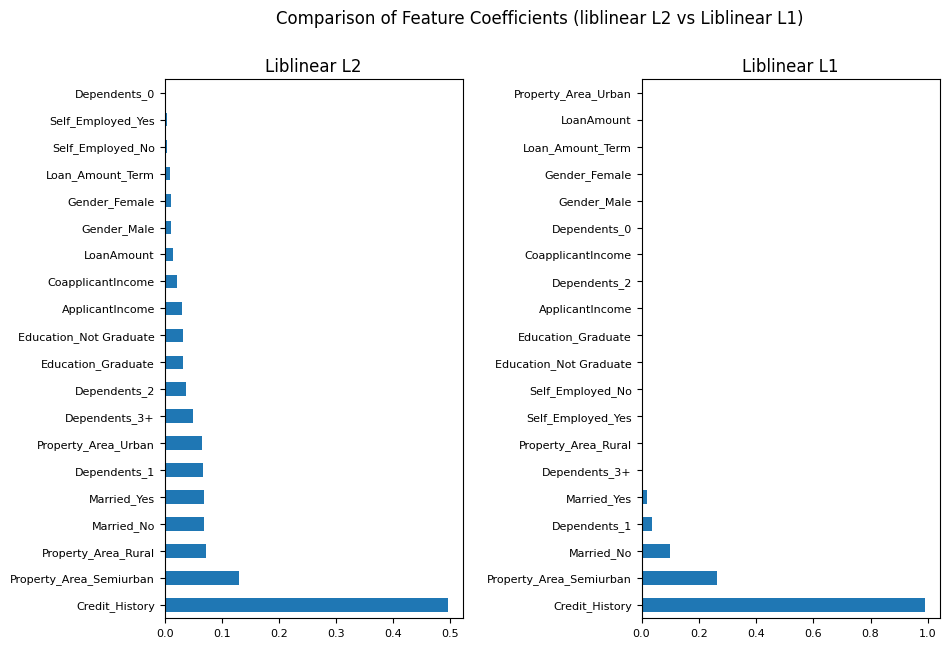

In [189]:
# compare Liblinear L2 vs Liblinear L1 feature weights

fig1, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
fig1.suptitle('Comparison of Feature Coefficients (liblinear L2 vs Liblinear L1)', fontsize=12)

liblinear_coef.plot(ax=ax1, kind="barh", figsize=(10,7), title="Liblinear L2", legend=False, fontsize=8)
liblinear_coef2.plot(ax=ax2, kind="barh", figsize=(10,7), title="Liblinear L1", legend=False, fontsize=8)

plt.subplots_adjust(wspace=0.6)

plt.savefig("logreg_features.png")
plt.show()

Both of these models perform roughly at the same accuracy as the previous two without overfitting. That is a good sign. However, our overall accuracy is still relatively low. Comparing the most highly weighted features, we see that both of them chose Credit_History and Property_Area_Semiurban as the two most important features. Additionally, the first model has all of the second model's features in its top six. We can try fitting a model on only those six top features to see how it performs.

## Feature Selection

In [161]:
# create a new X and one-hot-encode
X3 = df2.iloc[:,0:-1]
X3 = pd.get_dummies(X3)

In [162]:
# only grab the top eight columns and assign it back to X3
top_coef = list(liblinear_coef.index[0:6])
X3 = X3[top_coef]

In [163]:
# split the data
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.3, random_state=42)

In [164]:
# Creating a scaler object
scaler3 = StandardScaler() 

# Fitting and transforming the original data to scaled data
X_train3 = scaler3.fit_transform(X_train3)
X_test3 = scaler3.transform(X_test3)

In [165]:
parameters5 = {"C":strength, "solver":solvers,
              "random_state":[42], "max_iter":[3000], "penalty":["l2"]}
lr5 = LogisticRegression()
clf5 = GridSearchCV(lr5, parameters5, return_train_score=True)
clf5.fit(X_train3, y_train3)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [3000],
                         'penalty': ['l2'], 'random_state': [42],
                         'solver': ['lbfgs', 'liblinear', 'saga', 'sag',
                                    'newton-cg']},
             return_train_score=True)

In [166]:
print("Parameters:",clf5.best_params_)
print("Train Score:", clf5.cv_results_["mean_train_score"].max())
print("Test Score:", clf5.best_score_)

Parameters: {'C': 0.01, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
Train Score: 0.8140992609668454
Test Score: 0.8134610123119016


In [167]:
liblinear3 = clf5.best_estimator_
liblinear3.fit(X_train3, y_train3)

LogisticRegression(C=0.01, max_iter=3000, random_state=42, solver='liblinear')

In [168]:
# test the model for training and testing accuracy
print("Training Accuracy:", liblinear3.score(X_train3, y_train3))
print("Testing Accuracy:", liblinear3.score(X_test3, y_test3))

Training Accuracy: 0.8135198135198135
Testing Accuracy: 0.7783783783783784


Wow! Interestingly, removing all the other features resulted in the same accuracy score. However, I will note that the GridSearch returned liblinear which is the model that only use six features. Therefore, it makes sense that it would produce a similar or identical score.

In [76]:
# what if we only use the top two features
X4 = X3[X3.columns[0:2]]

# split the data
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y, test_size=0.3, random_state=42)

# Creating a scaler object
scaler4 = StandardScaler() 

# Fitting and transforming the original data to scaled data
X_train4 = scaler4.fit_transform(X_train4)
X_test4 = scaler4.transform(X_test4)

In [77]:
parameters6 = {"C":strength, "solver":solvers,
              "random_state":[42], "max_iter":[3000], "penalty":["l2"]}
lr6 = LogisticRegression()
clf6 = GridSearchCV(lr6, parameters6, return_train_score=True)
clf6.fit(X_train4, y_train4)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [3000],
                         'penalty': ['l2'], 'random_state': [42],
                         'solver': ['lbfgs', 'liblinear', 'saga', 'sag',
                                    'newton-cg']},
             return_train_score=True)

In [78]:
print("Parameters:",clf6.best_params_)
print("Train Score:", clf6.cv_results_["mean_train_score"].max())
print("Test Score:", clf6.best_score_)

Parameters: {'C': 0.001, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
Train Score: 0.8135161705878365
Test Score: 0.8134610123119016


In [79]:
liblinear4 = clf6.best_estimator_
liblinear4.fit(X_train4, y_train4)

# test the model for training and testing accuracy
print("Training Accuracy:", liblinear4.score(X_train4, y_train4))
print("Testing Accuracy:", liblinear4.score(X_test4, y_test4))

Training Accuracy: 0.8135198135198135
Testing Accuracy: 0.7783783783783784


In [80]:
y_pred3 = liblinear4.predict(X_test4)
print("Liblinear L2 Classification Report with Two Features:")
print(classification_report(y_test4, y_pred3, target_names=("No","Yes")))

Liblinear L2 Classification Report with Two Features:
              precision    recall  f1-score   support

          No       0.85      0.45      0.59        65
         Yes       0.76      0.96      0.85       120

    accuracy                           0.78       185
   macro avg       0.81      0.70      0.72       185
weighted avg       0.79      0.78      0.76       185



Even taking the top two features produces the same accuracy score. This means that we can greatly simplify our model while not losing accuracy.

## SVM

We will now train our models using SVM. We will continue with the modified and simplified features that exclude the loan ID.

In [81]:
from sklearn import svm

In [82]:
svm_params = {"kernel":["linear", "rbf", "poly", "sigmoid"], "random_state":[42], "C":strength}

svc = svm.SVC()
svc_svm = GridSearchCV(svc, svm_params, return_train_score=True)

In [83]:
svc_svm.fit(X_train2, y_train2)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                         'random_state': [42]},
             return_train_score=True)

In [84]:
print("Parameters:",svc_svm.best_params_)
print("Train Score:", svc_svm.cv_results_["mean_train_score"].max())
print("Test Score:", svc_svm.best_score_)

Parameters: {'C': 0.01, 'kernel': 'linear', 'random_state': 42}
Train Score: 0.9120025086446539
Test Score: 0.8134610123119016


The linear kernel performed best at a regularization strength of 0.01. Let us check if there is overfitting.

In [85]:
svclinear = svm.SVC()
svclinear.set_params(**svc_svm.best_params_)
svclinear.get_params()

{'C': 0.01,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [86]:
svclinear.fit(X_train2, y_train2)

SVC(C=0.01, kernel='linear', random_state=42)

In [87]:
# test the model for training and testing accuracy
print("Training Accuracy:", svclinear.score(X_train2, y_train2))
print("Testing Accuracy:", svclinear.score(X_test2, y_test2))

Training Accuracy: 0.8135198135198135
Testing Accuracy: 0.7783783783783784


The results are identical to our logistic regression using liblinear. 

In [88]:
y_pred4 = svclinear.predict(X_test2)
print("Linear Kernel SVM Classification Report:")
print(classification_report(y_test2, y_pred4, target_names=("No","Yes")))

Linear Kernel SVM Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.45      0.59        65
         Yes       0.76      0.96      0.85       120

    accuracy                           0.78       185
   macro avg       0.81      0.70      0.72       185
weighted avg       0.79      0.78      0.76       185



In [89]:
# fit the training data with only two top features
svc_svm.fit(X_train4, y_train4)

print("Parameters:",svc_svm.best_params_)
print("Train Score:", svc_svm.cv_results_["mean_train_score"].max())
print("Test Score:", svc_svm.best_score_)

Parameters: {'C': 0.01, 'kernel': 'linear', 'random_state': 42}
Train Score: 0.8135161705878365
Test Score: 0.8134610123119016


In [90]:
svclinear2 = svc_svm.best_estimator_

svclinear2.fit(X_train4, y_train4)
# test the model for training and testing accuracy
print("Training Accuracy:", svclinear2.score(X_train4, y_train4))
print("Testing Accuracy:", svclinear2.score(X_test4, y_test4))

Training Accuracy: 0.8135198135198135
Testing Accuracy: 0.7783783783783784


In [91]:
# map feature names to coeff in a df
linear_coef = pd.DataFrame(data=abs(svclinear.coef_),columns=short_features)
# transpose the df for better readibility
linear_coef = linear_coef.T
linear_coef.rename(columns={0:"Features"},inplace=True)
# sort by top coeff values
top_linear = linear_coef.sort_values(by="Features",ascending=False).head(20)
top_linear

,Features
Credit_History,0.717072
LoanAmount,0.000038
CoapplicantIncome,0.000034
Dependents_3+,0.000020
Property_Area_Semiurban,0.000019
ApplicantIncome,0.000017
Property_Area_Urban,0.000015
Married_No,0.000011
Married_Yes,0.000011
Dependents_2,0.000010


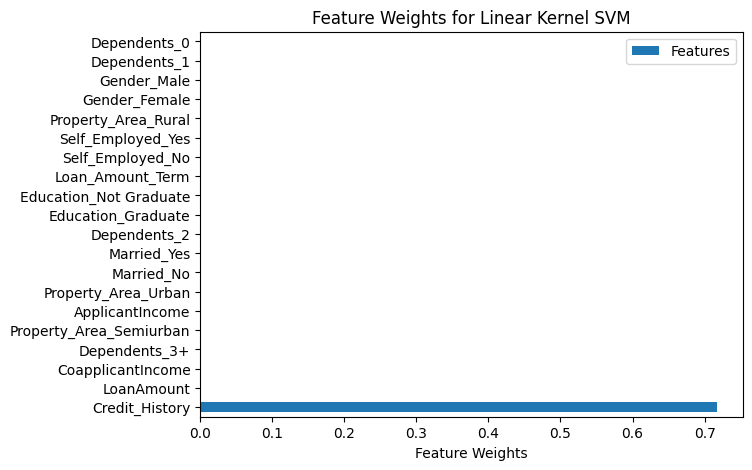

In [270]:
# Plot the feature weights
top_linear.plot(kind="barh", figsize=(7,5))
plt.xlabel("Feature Weights")
plt.title("Feature Weights for Linear Kernel SVM")
plt.show()

Despite producing the same accuracy scores, the SVM linear kernel put weights on the features in a different order.

## Decision Trees

Now we will continue our analysis using decision tree classifiers.

In [92]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [93]:
# create a list of max depths to test
depths = [1,3,6,9,12,15,18]

In [94]:
tree_params = {"criterion":["gini", "entropy"], "random_state":[42], "max_depth":depths}

dtc = DecisionTreeClassifier()
tree_classifier = GridSearchCV(dtc, tree_params, cv=5, return_train_score=True)

In [95]:
tree_classifier.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 6, 9, 12, 15, 18],
                         'random_state': [42]},
             return_train_score=True)

In [96]:
print("Parameters:",tree_classifier.best_params_)
print("Train Score:", tree_classifier.cv_results_["mean_train_score"].max())
print("Test Score:", tree_classifier.best_score_)

Parameters: {'criterion': 'gini', 'max_depth': 1, 'random_state': 42}
Train Score: 1.0
Test Score: 0.8134610123119016


In [97]:
gini = tree_classifier.best_estimator_

In [98]:
gini.fit(X_train2, y_train2)

DecisionTreeClassifier(max_depth=1, random_state=42)

In [99]:
# test the model for training and testing accuracy
print("Training Accuracy:", gini.score(X_train2, y_train2))
print("Testing Accuracy:", gini.score(X_test2, y_test2))

Training Accuracy: 0.8135198135198135
Testing Accuracy: 0.7783783783783784


Once again our accuracy scores are identical. It is odd that the highest score was reached at max depth of 1. That seems like it should not happen. For curiousity, let us try manually using different max depths to see what the scores are.

In [100]:
# change the depth to 3
gini.max_depth = 3
gini.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [101]:
# fit again
gini.fit(X_train2, y_train2)

# test the model for training and testing accuracy
print("Training Accuracy:", gini.score(X_train2, y_train2))
print("Testing Accuracy:", gini.score(X_test2, y_test2))

Training Accuracy: 0.8275058275058275
Testing Accuracy: 0.7783783783783784


In [102]:
gini.max_depth = 18
gini.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 18,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [103]:
# fit again
gini.fit(X_train2, y_train2)

# test the model for training and testing accuracy
print("Training Accuracy:", gini.score(X_train2, y_train2))
print("Testing Accuracy:", gini.score(X_test2, y_test2))

Training Accuracy: 1.0
Testing Accuracy: 0.6756756756756757


Increasing our max depth improved the training accuracy but either did not affect the testing or decreased it altogether. It seems that the GridSearchCV did identify the highest performing tree depth.

We know that decision trees are scalable. Perhaps, we can try using the unscaled dataset to see if it makes a difference.

In [104]:
X5 = df2.iloc[:,0:-1]
X5 = pd.get_dummies(X5)

In [105]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y, test_size=0.3, random_state=42)

In [106]:
# fit again using the unscaled features
gini.max_depth = 1
gini.fit(X_train5, y_train5)

# test the model for training and testing accuracy
print("Training Accuracy:", gini.score(X_train5, y_train5))
print("Testing Accuracy:", gini.score(X_test5, y_test5))

Training Accuracy: 0.8135198135198135
Testing Accuracy: 0.7783783783783784


In [107]:
gini.max_depth = 3
gini.fit(X_train5, y_train5)

# test the model for training and testing accuracy
print("Training Accuracy:", gini.score(X_train5, y_train5))
print("Testing Accuracy:", gini.score(X_test5, y_test5))

Training Accuracy: 0.8275058275058275
Testing Accuracy: 0.7837837837837838


In [108]:
gini.max_depth = 5
gini.fit(X_train5, y_train5)

# test the model for training and testing accuracy
print("Training Accuracy:", gini.score(X_train5, y_train5))
print("Testing Accuracy:", gini.score(X_test5, y_test5))

Training Accuracy: 0.8391608391608392
Testing Accuracy: 0.7837837837837838


In [109]:
gini.max_depth = 3
gini.fit(X_train5, y_train5)

y_pred5 = gini.predict(X_test5)
print("Decision Tree Classification Report:")
print(classification_report(y_test5, y_pred5, target_names=("No","Yes")))

Decision Tree Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.46      0.60        65
         Yes       0.77      0.96      0.85       120

    accuracy                           0.78       185
   macro avg       0.81      0.71      0.73       185
weighted avg       0.80      0.78      0.76       185



In [231]:
# create a dataframe with top weighted features for gini
gini_importances = pd.DataFrame({'feature':long_features,'importance':np.round(gini.feature_importances_,3)})
gini_importances = gini_importances.sort_values('importance',ascending=False).head(30)
gini_importances.reset_index(drop=True, inplace=True)
gini_importances

,feature,importance
0,Credit_History,0.808
1,Loan_Amount_Term,0.052
2,Property_Area_Semiurban,0.051
3,CoapplicantIncome,0.038
4,Loan_ID_LP001677,0.026
5,Loan_ID_LP002478,0.025
6,ApplicantIncome,0.000
7,Loan_ID_LP002357,0.000
8,Loan_ID_LP002335,0.000
9,Loan_ID_LP002337,0.000


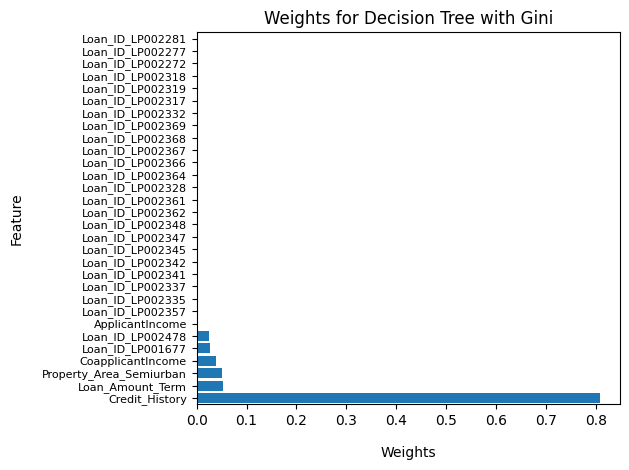

In [265]:
# Plot the feature importances
plt.barh(y="feature", data=gini_importances, width=gini_importances.importance)
plt.title("Weights for Decision Tree with Gini")
plt.ylabel("Feature", labelpad=13)
plt.xlabel("Weights", labelpad=13)
plt.yticks(fontsize=8)
plt.ylim([min(range(30)) - 0.5, max(range(30)) + 0.5])
plt.tight_layout()
plt.show()

At max depth of 3, we saw the highest testing accuracy so far. We used the unscaled features and it seemed to help a little bit. Looking at the top features for unscaled data, it is interesting that several identifiers for loan application actually received some weight. The top two features were still credit_history and property_area_semiurban.

However, we have yet to hit 80 percent for any of our models. We will try ensemble methods next.

## Gradient Boosting

In [111]:
from sklearn.ensemble import GradientBoostingClassifier

In [112]:
gbc_parameters = {"n_estimators":[100, 150, 200], "learning_rate":[0.001, 0.01, 0.1, 1, 10], "random_state":[42], 
                  "max_depth":depths}

gbc = GradientBoostingClassifier()
gb_classifier = GridSearchCV(gbc, gbc_parameters, cv=5, return_train_score=True)

In [113]:
gb_classifier.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'max_depth': [1, 3, 6, 9, 12, 15, 18],
                         'n_estimators': [100, 150, 200],
                         'random_state': [42]},
             return_train_score=True)

In [114]:
print("Parameters:",gb_classifier.best_params_)
print("Train Score:", gb_classifier.cv_results_["mean_train_score"].max())
print("Test Score:", gb_classifier.best_score_)

Parameters: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 100, 'random_state': 42}
Train Score: 1.0
Test Score: 0.8134610123119016


In [115]:
gbc_model = gb_classifier.best_estimator_

gbc_model.fit(X_train2, y_train2)

# test the model for training and testing accuracy
print("Training Accuracy:", gbc_model.score(X_train2, y_train2))
print("Testing Accuracy:", gbc_model.score(X_test2, y_test2))

Training Accuracy: 0.8135198135198135
Testing Accuracy: 0.7783783783783784


In [116]:
# let us do a gridsearch with the unscaled data

gbc_parameters = {"n_estimators":[100, 150, 200], "learning_rate":[0.001, 0.01, 0.1, 1,10], "random_state":[42], 
                  "max_depth":depths}

gbc2 = GradientBoostingClassifier()
gb_classifier2 = GridSearchCV(gbc2, gbc_parameters, cv=5, return_train_score=True)

gb_classifier2.fit(X_train5, y_train5)

print("Parameters:",gb_classifier2.best_params_)
print("Train Score:", gb_classifier2.cv_results_["mean_train_score"].max())
print("Test Score:", gb_classifier2.best_score_)

Parameters: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 100, 'random_state': 42}
Train Score: 1.0
Test Score: 0.8134610123119016


In [117]:
gbc_model2 = gb_classifier2.best_estimator_

gbc_model2.fit(X_train5, y_train5)

# test the model for training and testing accuracy
print("Training Accuracy:", gbc_model2.score(X_train5, y_train5))
print("Testing Accuracy:", gbc_model2.score(X_test5, y_test5))

Training Accuracy: 0.8135198135198135
Testing Accuracy: 0.7783783783783784


In [118]:
y_pred6 = gbc_model2.predict(X_test5)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test5, y_pred6, target_names=("No","Yes")))

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.45      0.59        65
         Yes       0.76      0.96      0.85       120

    accuracy                           0.78       185
   macro avg       0.81      0.70      0.72       185
weighted avg       0.79      0.78      0.76       185



In [119]:
# create a dataframe with top weighted features for gbc
gbc_importances = pd.DataFrame({'feature':long_features,'importance':np.round(gbc_model2.feature_importances_,3)})
gbc_importances = gbc_importances.sort_values('importance',ascending=False).head(50)
gbc_importances

,feature,importance
4,Credit_History,1.0
0,ApplicantIncome,0.0
426,Loan_ID_LP002357,0.0
419,Loan_ID_LP002335,0.0
420,Loan_ID_LP002337,0.0
421,Loan_ID_LP002341,0.0
422,Loan_ID_LP002342,0.0
423,Loan_ID_LP002345,0.0
424,Loan_ID_LP002347,0.0
425,Loan_ID_LP002348,0.0


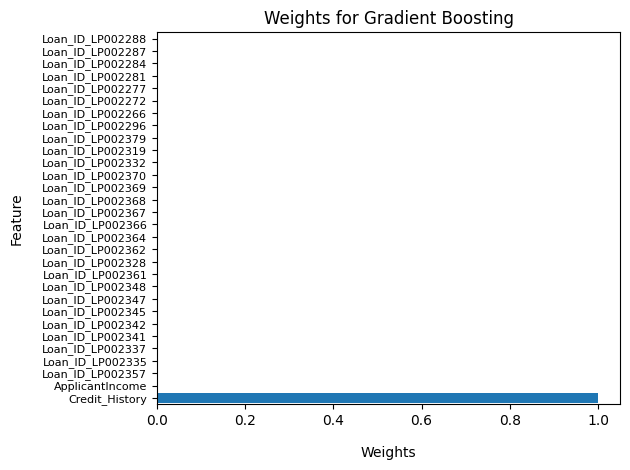

In [266]:
# Plot the feature importances
plt.barh(y="feature", data=gbc_importances, width=gbc_importances.importance)
plt.title("Weights for Gradient Boosting")
plt.ylabel("Feature", labelpad=13)
plt.xlabel("Weights", labelpad=13)
plt.yticks(fontsize=8)
plt.ylim([min(range(30)) - 0.5, max(range(30)) + 0.5])
plt.tight_layout()
plt.show()

Our multiple attempts with gradient boosting resulted in the same accuracy as before. However, our important features are different from the decision tree classifier. While credit_history remains the most important feature, all others have no weight.

## Multi-Layer Perceptron (MLP) Neural Network Classifier

We now move on to our final model for this analysis. MLP is a perceptron model that contains multiple layers thus allowing it to learn non-linear relationships. It works for both regression and classification problems. We will experiment to see if it can improve upon the results of previous models. If not, it is possible that our dataset needs additional transformations.

In [120]:
from sklearn.neural_network import MLPClassifier

In [121]:
# MLP requires scaled data so we will use the scaled version here

alpha = 10.0 ** -np.arange(1, 7)

mlp_parameters = {"activation":['identity', 'logistic', 'tanh', 'relu'], 
                  "solver":['adam', 'lbfgs', 'sgd'], 
                  "hidden_layer_sizes":[(15,), (30,), (60,), (100,)], 
                  "alpha":alpha,
                  "random_state":[42], "max_iter":[10000]}

mlp = MLPClassifier()
mlp_classifier = GridSearchCV(mlp, mlp_parameters, cv=5, return_train_score=True)

In [122]:
mlp_classifier.fit(X_train2, y_train2)

GridSearchCV(cv=5, error_score='raise', estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
                         'hidden_layer_sizes': [(15,), (30,), (60,), (100,)],
                         'max_iter': [10000], 'random_state': [42],
                         'solver': ['adam', 'lbfgs', 'sgd']},
             return_train_score=True)

In [123]:
print("Parameters:",mlp_classifier.best_params_)
print("Train Score:", mlp_classifier.cv_results_["mean_train_score"].max())
print("Test Score:", mlp_classifier.best_score_)

Parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (30,), 'max_iter': 10000, 'random_state': 42, 'solver': 'sgd'}
Train Score: 1.0
Test Score: 0.8134610123119016


In [124]:
mlp_model = mlp_classifier.best_estimator_

In [125]:
mlp_model.fit(X_train2, y_train2)

MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=(30,),
              max_iter=10000, random_state=42, solver='sgd')

In [126]:
# test the model for training and testing accuracy
print("Training Accuracy:", mlp_model.score(X_train2, y_train2))
print("Testing Accuracy:", mlp_model.score(X_test2, y_test2))

Training Accuracy: 0.8158508158508159
Testing Accuracy: 0.7783783783783784


In [127]:
y_pred7 = mlp_model.predict(X_test2)
print("MLP Classification Report:")
print(classification_report(y_test2, y_pred7, target_names=("No","Yes")))

MLP Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.45      0.59        65
         Yes       0.76      0.96      0.85       120

    accuracy                           0.78       185
   macro avg       0.81      0.70      0.72       185
weighted avg       0.79      0.78      0.76       185



As with all the other models that I've tried, I ended up with the same accruacy scores and similar precision, recall, and F1 scores. Based on the better performance predicting the majority class, the imbalance in our dataset may be causing the accuracy to peak at 78 percent.

# Oversampling the Data

We will try oversampling the data to arrive at an even distribution of classes. This may improve our models.

In [128]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)

In [129]:
#oversample the no class data to equal the samples of the majority class
X_res, y_res = ros.fit_resample(X2, y)

In [130]:
print("Size of X:",X_res.shape, "Size of Y:", y_res.shape)

Size of X: (844, 20) Size of Y: (844,)


In [131]:
# check that the classes are even
np.unique(y_res, return_counts=True)

(array([0, 1]), array([422, 422], dtype=int64))

In [132]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [133]:
# scale the features
scaler5 = StandardScaler() 

# Fitting and transforming the original data to scaled data
X_train6 = scaler5.fit_transform(X_train6)
X_test6 = scaler5.transform(X_test6)

### L2 Regularization with Oversampling

In [134]:
# L2 regularization GridSearch
clf.fit(X_train6, y_train6)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [3000],
                         'penalty': ['l2'], 'random_state': [42],
                         'solver': ['lbfgs', 'liblinear', 'saga', 'sag',
                                    'newton-cg']},
             return_train_score=True)

In [135]:
print("Parameters:",clf.best_params_)
print("Train Score:", clf.cv_results_["mean_train_score"].max())
print("Test Score:", clf.best_score_)

Parameters: {'C': 0.1, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
Train Score: 0.760593220338983
Test Score: 0.7389830508474576


### L1 Regularization with Oversampling

In [136]:
# L1 regularization GridSearch
clf2.fit(X_train6, y_train6)

print("Parameters:",clf2.best_params_)
print("Train Score:", clf2.cv_results_["mean_train_score"].max())
print("Test Score:", clf2.best_score_)

Parameters: {'C': 0.01, 'max_iter': 7000, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Train Score: 0.7627118644067796
Test Score: 0.735593220338983


### MLP with Oversampling

In [137]:
# give MLP a try
mlp_classifier.fit(X_train6, y_train6)

print("Parameters:",mlp_classifier.best_params_)
print("Train Score:", mlp_classifier.cv_results_["mean_train_score"].max())
print("Test Score:", mlp_classifier.best_score_)

Parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (60,), 'max_iter': 10000, 'random_state': 42, 'solver': 'lbfgs'}
Train Score: 1.0
Test Score: 0.8389830508474576


In [139]:
mlp_model2 = mlp_classifier.best_estimator_

In [140]:
mlp_model2.fit(X_train6, y_train6)

# test the model for training and testing accuracy
print("Training Accuracy:", mlp_model2.score(X_train6, y_train6))
print("Testing Accuracy:", mlp_model2.score(X_test6, y_test6))

Training Accuracy: 0.9983050847457627
Testing Accuracy: 0.7992125984251969


In [141]:
y_pred8 = mlp_model.predict(X_test6)
print("MLP with Oversampling Classification Report:")
print(classification_report(y_test6, y_pred8, target_names=("No","Yes")))

MLP with Oversampling Classification Report:
              precision    recall  f1-score   support

          No       0.78      0.87      0.82       136
         Yes       0.83      0.72      0.77       118

    accuracy                           0.80       254
   macro avg       0.80      0.79      0.80       254
weighted avg       0.80      0.80      0.80       254



Oversampling did not solve our problem. In fact, our accuracy went down for logistic regression. It reached its highest accuracy for MLP but it is overfitting based on the wide gap between training and testing accuracy.

# Summary

This has been exciting exploration of a home loan prediction dataset. We tried many different hyperparameters for logistic regression, SVM, decision trees, gradient boosting, and MLP. Additionally, we tried removing features, standardizing data, and using unscaled and complete data. We saw that credit history was the most important feature which makes sense because we are predicting loan acceptance. We also discovered that no matter what changes we make, the accuracy does not reach or pass 80 percent. However, we know the models are not just memorizing the training data or picking only the majority class because the accuracy is higher than the proportion of the data belonging to the majority class.

There does not appear to be more data that we can use to extend the dataset at this time so the models performed as best as they could with available data. It is likely that the approval of loans was a bit random and dependent on factors beyond the features in the data. This could include things such as the assigned loan officer, prior relationship with this home loan provider, previous approved loans for this applicant, etc.